###### <b> Step-1 : Importing Libraries</b>

In [10]:
import os                               
import cv2
import time                              
import numpy as np  
from PIL import Image
import tensorflow as tf 
from google.colab import drive
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###### <b> Step-2: Mounting Google Drive</b>

In [11]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


######<b> Step-3 : Set Path for Training, Testing and Validation Directories</b>

In [12]:
base_dir = '/content/drive/MyDrive/Skin Cancer Dataset'
train_dir = '/content/drive/MyDrive/Skin Cancer Dataset/train'
validations_dir = '/content/drive/MyDrive/Skin Cancer Dataset/validation'
test_dir = '/content/drive/MyDrive/Skin Cancer Dataset/test'

In [13]:
train_benign_dir = '/content/drive/MyDrive/Skin Cancer Dataset/train/benign'
train_malignant_dir = '/content/drive/MyDrive/Skin Cancer Dataset/train/malignant'

validation_benign_dir = '/content/drive/MyDrive/Skin Cancer Dataset/validation/benign'
validation_malignant_dir = '/content/drive/MyDrive/Skin Cancer Dataset/validation/malignant'

test_benign_dir = '/content/drive/MyDrive/Skin Cancer Dataset/test/benign'
test_malignant_dir = '/content/drive/MyDrive/Skin Cancer Dataset/test/malignant'

In [14]:
num_benign_train = len(os.listdir(train_benign_dir))
num_malignant_train = len(os.listdir(train_malignant_dir))

num_benign_validaition = len(os.listdir(validation_benign_dir))
num_malignant_validation= len(os.listdir(validation_malignant_dir))

num_benign_test = len(os.listdir(test_benign_dir))
num_malignant_test= len(os.listdir(test_malignant_dir))

In [17]:
print("Total Training Benign Images",num_benign_train)
print("Total Training Malignant Images",num_malignant_train)
print("-------------------------------")
print("Total validation Benign Images",num_benign_validaition)
print("Total validation Malignant Images",num_malignant_validation)
print("-------------------------------")
print("Total Test Benign Images", num_benign_test)
print("Total Test Malignant Images",num_malignant_test)

Total Training Benign Images 1140
Total Training Malignant Images 937
-------------------------------
Total validation Benign Images 300
Total validation Malignant Images 260
-------------------------------
Total Test Benign Images 360
Total Test Malignant Images 300


In [18]:
total_train = num_benign_train+num_malignant_train
total_validation = num_benign_validaition+num_malignant_validation
total_test = num_benign_test+num_malignant_test
print("Total Training Images",total_train)
print("-----------------------")
print("Total Validation Images",total_validation)
print("-----------------------")
print("Total Testing Images",total_test)

Total Training Images 2077
-----------------------
Total Validation Images 560
-----------------------
Total Testing Images 660


###### <b> Step-4 : defining batch and image Size for model training</b>

In [19]:
IMG_SHAPE  = 224
batch_size = 32

###### <b> Step-5 : Make function for displaying Random Images</b>

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

###### <b>Step-6 : Applying Data Augmentation and Pre-Processing on training Data</b>

In [21]:
image_gen_train = ImageDataGenerator(rescale = 1./255,rotation_range = 90,
                                     width_shift_range=0.3,height_shift_range=0.3,
                                     shear_range = 0.3,zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary')

Found 2077 images belonging to 2 classes.


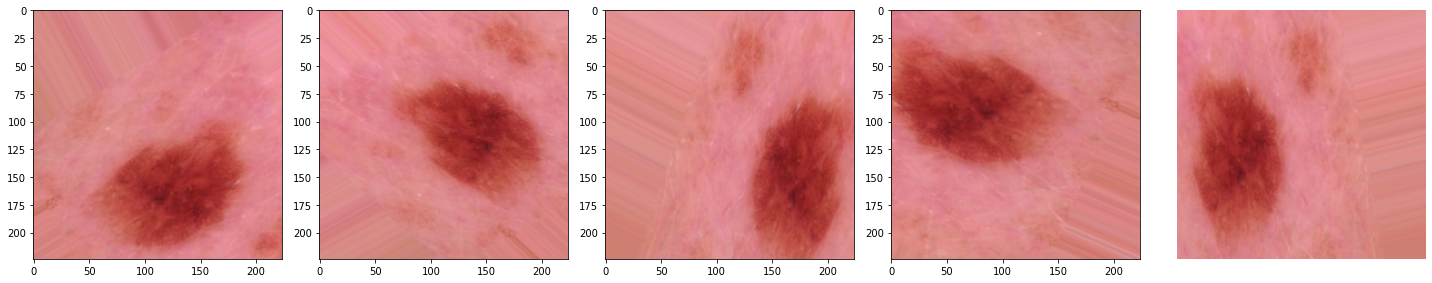

In [25]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

###### <B> Step-7 : Applying pre-processing on validation & Testing Data</b>

In [26]:
image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
                                                 directory=validations_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                  class_mode='binary')

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 560 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


###### <b>Step-8 : Let check names of classes</b>

In [27]:
train_data_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

###### <b>Step-9 : Setting Models Parameters</b>

In [28]:
skin_classifier = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(16,(3,3),activation = tf.nn.relu,input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(32,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(128,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = tf.nn.relu),
        tf.keras.layers.Dense(2,activation = tf.nn.sigmoid)  
])

###### <b> Step-10 : Compiling model parameters</b>

In [29]:
skin_classifier.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

###### <b> Step-11 : View Summary of model before training</b>

In [30]:
skin_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

###### <b> Step-12 : Let's Start Training</b>

In [31]:
history_skin_classifier = skin_classifier.fit(train_data_gen,
                                              steps_per_epoch=65,
                                              epochs = 100,
                                              validation_data=val_data_gen,
                                              validation_steps=18,
                                              batch_size = batch_size,
                                              verbose = 1)

Epoch 1/100
65/65 [==============================] - 862s 13s/step - loss: 0.9694 - acc: 0.5705 - val_loss: 0.8068 - val_acc: 0.5357
Epoch 2/100
65/65 [==============================] - 29s 442ms/step - loss: 0.7563 - acc: 0.5364 - val_loss: 0.7255 - val_acc: 0.5339
Epoch 3/100
65/65 [==============================] - 28s 434ms/step - loss: 0.7120 - acc: 0.5484 - val_loss: 0.7014 - val_acc: 0.5357
Epoch 4/100
65/65 [==============================] - 28s 432ms/step - loss: 0.7126 - acc: 0.5142 - val_loss: 0.7052 - val_acc: 0.4411
Epoch 5/100
65/65 [==============================] - 29s 448ms/step - loss: 0.7004 - acc: 0.4983 - val_loss: 0.6944 - val_acc: 0.5357
Epoch 6/100
65/65 [==============================] - 28s 425ms/step - loss: 0.6968 - acc: 0.5489 - val_loss: 0.7003 - val_acc: 0.5357
Epoch 7/100
65/65 [==============================] - 29s 452ms/step - loss: 0.6969 - acc: 0.5489 - val_loss: 0.6950 - val_acc: 0.5357
Epoch 8/100
65/65 [==============================] - 28s 423ms/

###### <b> Step-13 : Checking history of models parameters</b>

In [32]:
history_dict = history_skin_classifier.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


##### <b> Step-13: Visualizing Accuracy and Loss results</b>

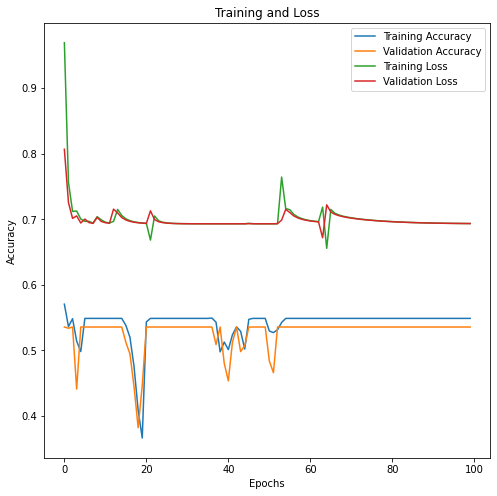

In [36]:
acc = history_skin_classifier.history['acc']
val_acc = history_skin_classifier.history['val_acc']

loss = history_skin_classifier.history['loss']
val_loss = history_skin_classifier.history['val_loss']

epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##### <B> Step-14 : Saving model</b>

In [38]:
model_json = skin_classifier.to_json()
with open("/content/drive/MyDrive/Skin Cancer Dataset/Skin_cancer_classification.json", "w") as json_file:
    json_file.write(model_json)
skin_classifier.save("/content/drive/MyDrive/Skin Cancer Dataset/Skin_cancer_classification.h5")
print("Saved model to disk")
skin_classifier.save_weights("/content/drive/MyDrive/Skin Cancer Dataset/SCC-Weights.h5")

Saved model to disk


######<b> Step-15 : Testing Model</b>

In [39]:
results = skin_classifier.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",results)

21/21 [==============================] - 214s 11s/step - loss: 0.6935 - acc: 0.5455
test_loss, test accuracy [0.6934964060783386, 0.5454545617103577]


###### <b> Step-16 : Checking Classification Matrix of Model</b>

In [40]:
prediction = skin_classifier.predict(test_data_gen)
pred_class = np.argmax(prediction, axis=1)

true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      benign       1.00      0.55      0.71       660
   malignant       0.00      0.00      0.00         0

    accuracy                           0.55       660
   macro avg       0.50      0.27      0.35       660
weighted avg       1.00      0.55      0.71       660



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### <b>Step-18 : Showing multiple images</b>

In [41]:
lr_probs = skin_classifier.predict(test_data_gen)
lr_probs = lr_probs[:, 1]

In [42]:
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)

##### <b>Step-21: Visulazing Precision and Recall</b>

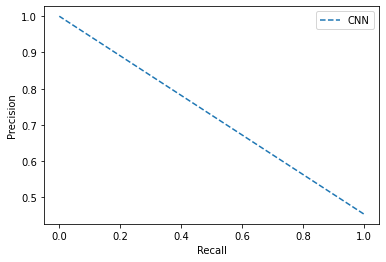

In [43]:
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#####<b>Step-22: Visualizing AUC & ROC Curves</b>

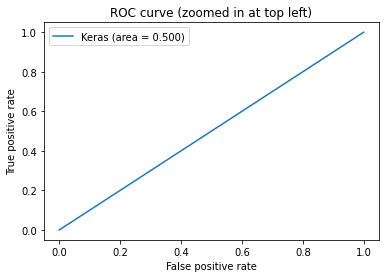

In [44]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()